In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('Titanic.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


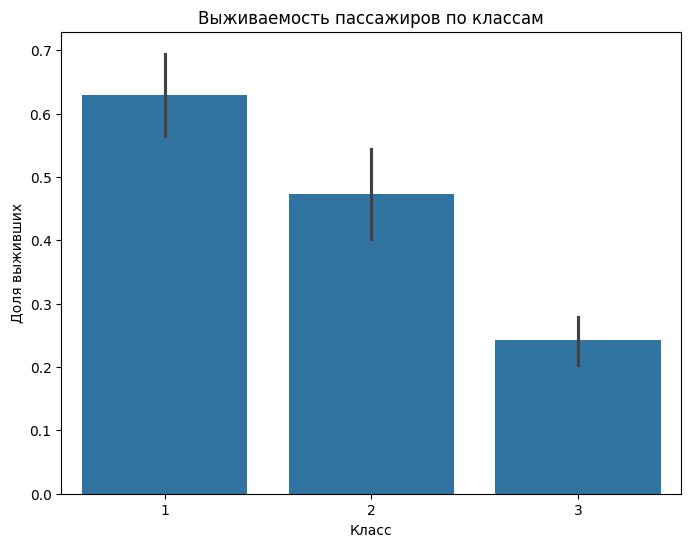

In [ ]:
# Выживаемость по классам
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Выживаемость пассажиров по классам')
plt.xlabel('Класс')
plt.ylabel('Доля выживших')
plt.show()

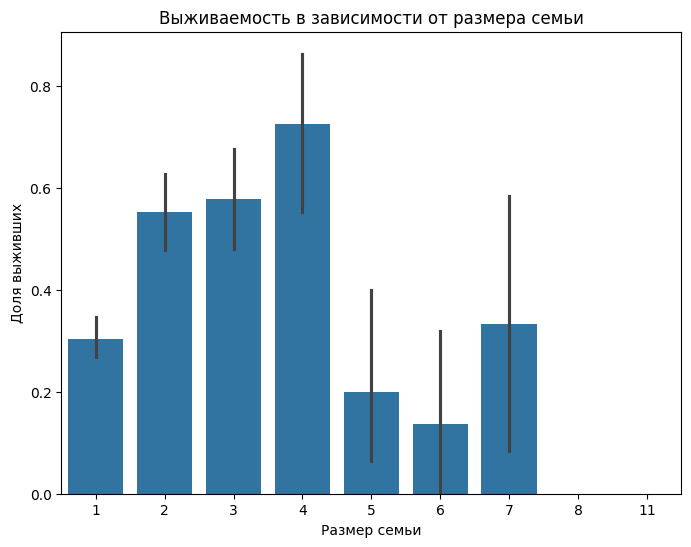

In [ ]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
plt.figure(figsize=(8, 6))
sns.barplot(x='FamilySize', y='Survived', data=df)
plt.title('Выживаемость в зависимости от размера семьи')
plt.xlabel('Размер семьи')
plt.ylabel('Доля выживших')
plt.show()

Пассажиры, путешествующие в одиночку, имели меньшие шансы на выживание по сравнению с теми, у кого были небольшие семьи (2-4 человека). Очень большие семьи (5+ человек) также имели низкие шансы на выживание.

Анализ по возрастным группамс шагом в 10 лет

<ipython-input-166-431e921ea93b>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_survival = df.groupby('AgeBin')['Survived'].mean() * 100


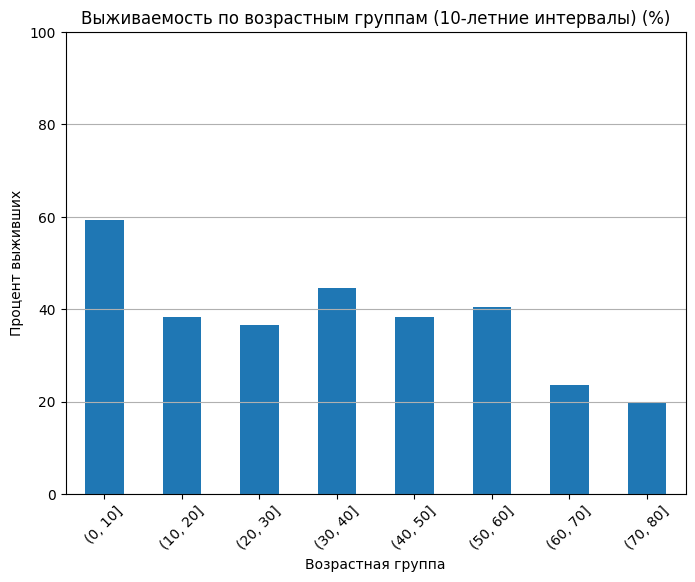

In [ ]:
df['AgeBin'] = pd.cut(df['Age'], bins=range(0, 90, 10))

age_bin_survival = df.groupby('AgeBin')['Survived'].mean() * 100

plt.figure(figsize=(8, 6))
age_bin_survival.plot(kind='bar')
plt.title('Выживаемость по возрастным группам (10-летние интервалы) (%)')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент выживших')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

Дети имели значительно большие шансы на выживание.

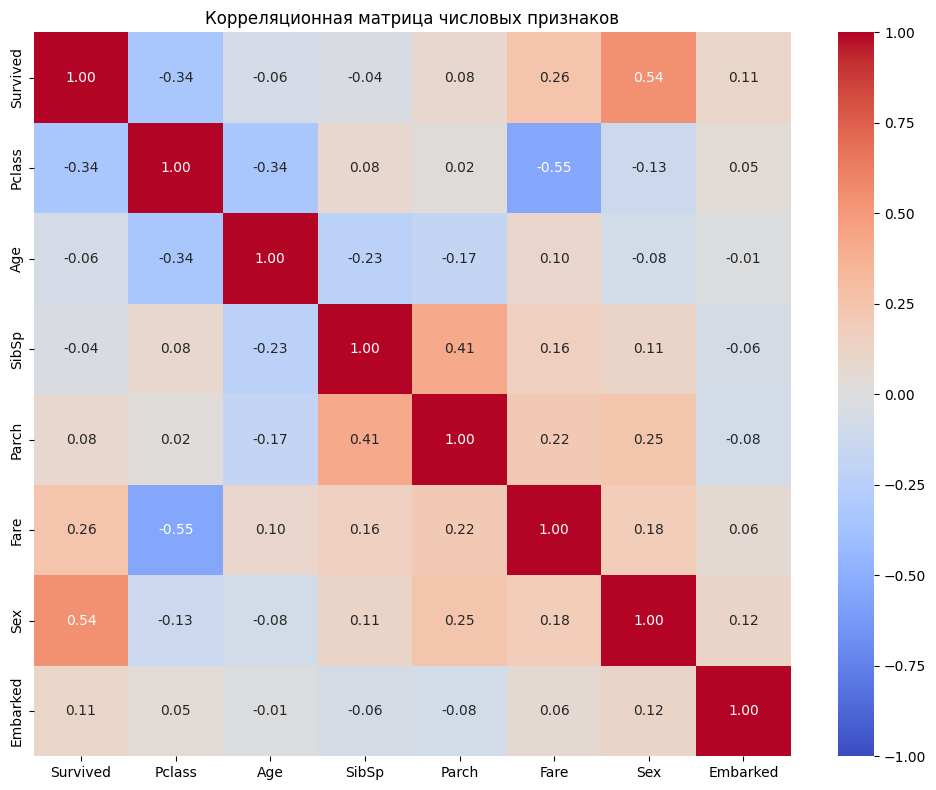

In [ ]:
df_corr = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].copy()

df_corr['Age'] = df_corr['Age'].fillna(df_corr['Age'].median())
df_corr['Fare'] = df_corr['Fare'].fillna(df_corr['Fare'].median())

df_corr['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df_corr['Embarked'] = df['Embarked'].fillna('S').map({'S': 0, 'C': 1, 'Q': 2})

plt.figure(figsize=(10, 8))
corr = df_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

Feature Engineering

In [ ]:
def feature_engineering(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3,
        'Dr': 4, 'Rev': 4, 'Col': 4, 'Major': 4,
        'Mlle': 1, 'Ms': 1, 'Lady': 4, 'Sir': 4,
        'Mme': 2, 'Don': 4, 'Capt': 4, 'Countess': 4,
        'Jonkheer': 4, 'Dona': 4
    }
    df['Title'] = df['Title'].map(title_mapping).fillna(4)

    df['Age'] = df['Age'].fillna(df.groupby(['Title', 'Pclass'])['Age'].transform('median'))

    df['Sex'] = df['Sex'].str.lower().str.strip()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).fillna(0)

    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).fillna(0)

    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('median'))

    return df

df_processed = feature_engineering(df)

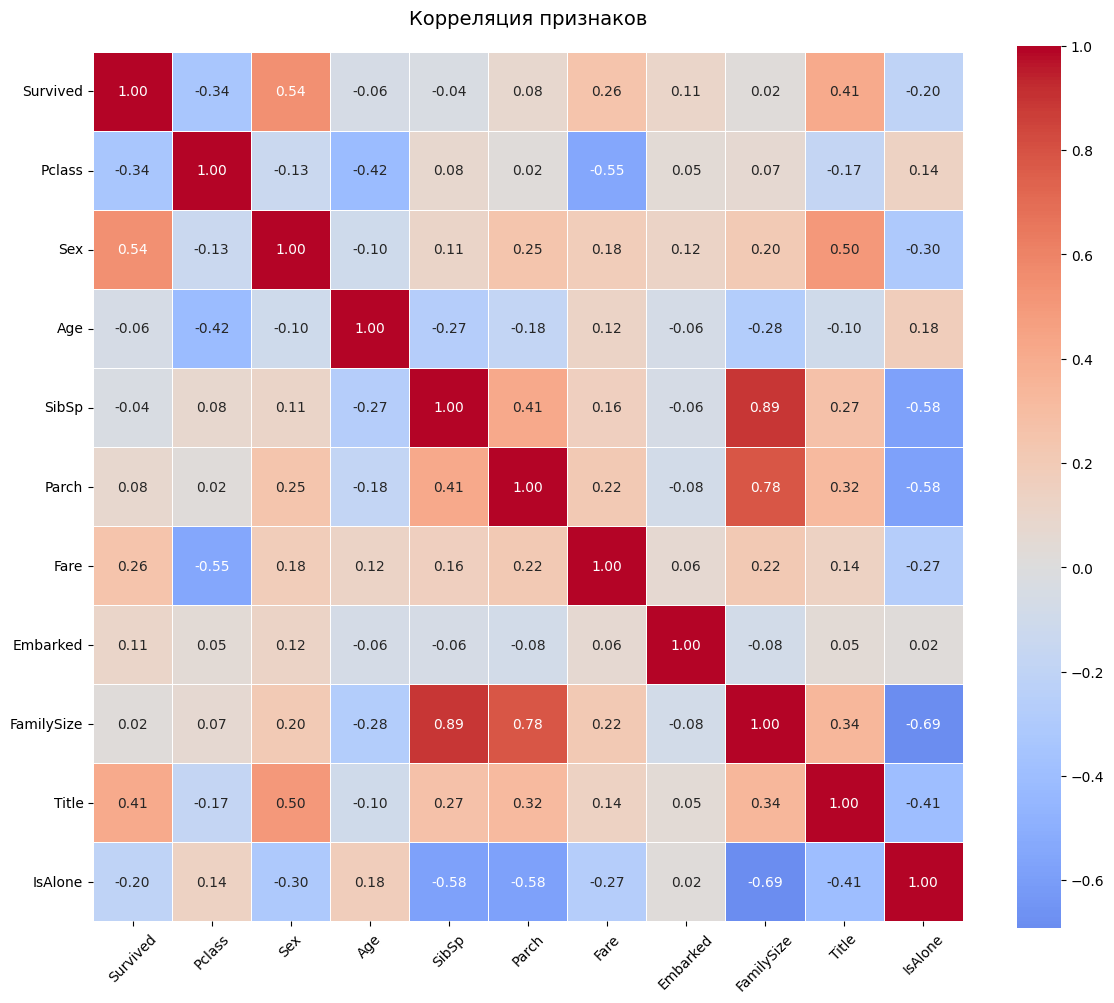

In [ ]:
corr_df = df_processed[[
    'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
    'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', "IsAlone"
]]

plt.figure(figsize=(12, 10))
corr = corr_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
            center=0, square=True, linewidths=.5)
plt.title('Корреляция признаков',
          pad=20, fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Колонка Title, признак, который на основе колонки "name" определяет соц статус пассажира.

Mr	0	Мужчина

Miss	1	Незамужняя женщина

Mrs	2	Замужняя женщина

Master	3	Мальчик

Rare	4	Аристократия, военные, доктора

Признак Sex имеет большую корреляцию, делаем вывод, что больше шансов выжить было у женщин и детей.

Title в целом показывает те же результаты что и Sex, потому что Title основывается на поле человека.

Pclass дает понять, что 1-й класс выживал чаще 3-го

Fare подтверждает Pclass и показывает, что с
повышением цены билета шанс выжить больше.

<ipython-input-189-5cab22b1750e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=scores, palette="viridis")


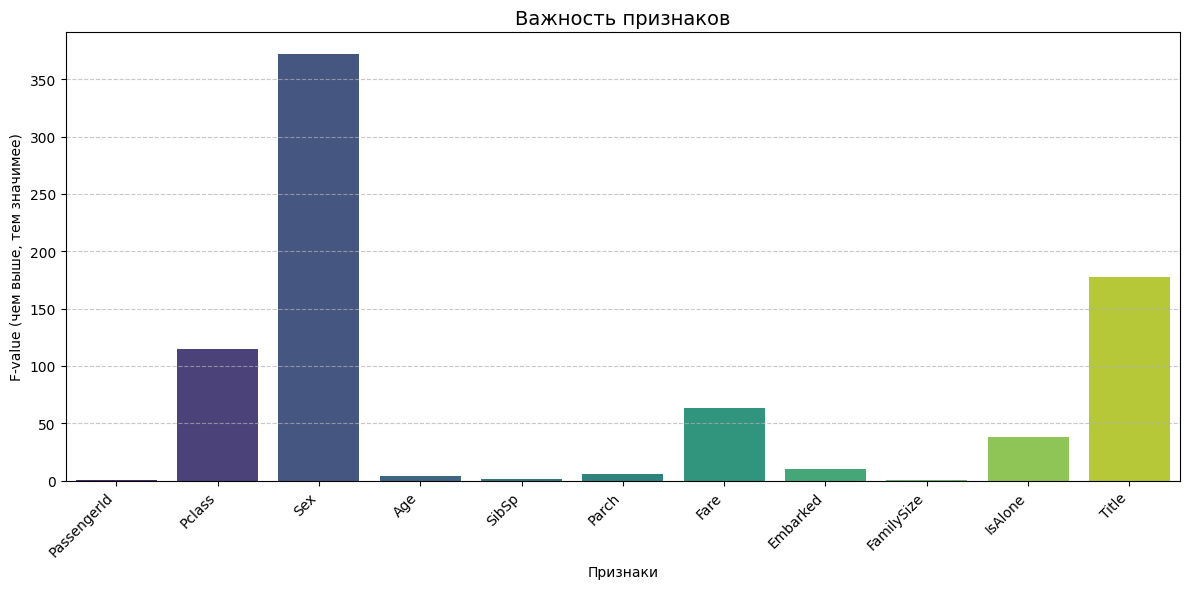

Топ-5 наиболее значимых признаков:
    Feature       Score
2       Sex  372.405724
10    Title  177.283027
1    Pclass  115.031272
6      Fare   63.030764
9   IsAlone   38.353651


In [ ]:
from sklearn.impute import SimpleImputer

numeric_features = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
X = df_processed[numeric_features].drop('Survived', axis=1)
y = df_processed['Survived']

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

selector = SelectKBest(f_classif, k=min(10, len(X.columns)))
selector.fit(X_imputed, y)
scores = selector.scores_

plt.figure(figsize=(12, 6))
sns.barplot(x=X.columns, y=scores, palette="viridis")
plt.title('Важность признаков', fontsize=14)
plt.xlabel('Признаки')
plt.ylabel('F-value')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
print("Топ-5 наиболее значимых признаков:")
print(feature_scores.sort_values('Score', ascending=False).head(5))

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

X = df_processed.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df_processed['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numeric_features = ['Age', 'Fare', 'Pclass','FamilySize', 'IsAlone']
categorical_features = ['Pclass', 'Sex', 'Fare', 'Title']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

models = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear']
        }
    },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'SVC',
        'model': SVC(probability=True, random_state=42),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'GradientBoosting',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_split': [2, 5]
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42, n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }
    },
]

In [ ]:
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_config in models:
    print(f"Настройка {model_config['name']}")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_config['model'])
    ])

    gs = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    gs.fit(X_train, y_train)
    best_models[model_config['name']] = gs.best_estimator_

    y_pred = gs.predict(X_test)
    y_proba = gs.predict_proba(X_test)[:, 1]

    print(f"\nРезультаты {model_config['name']}:")
    print(f"Лучшие параметры: {gs.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}\n")

Настройка LogisticRegression
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Результаты LogisticRegression:
Лучшие параметры: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Accuracy: 0.8492
F1: 0.8138
ROC-AUC: 0.8889

Настройка RandomForest
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Результаты RandomForest:
Лучшие параметры: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Accuracy: 0.8156
F1: 0.7626
ROC-AUC: 0.9041

Настройка SVC
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Результаты SVC:
Лучшие параметры: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Accuracy: 0.8603
F1: 0.8276
ROC-AUC: 0.9157

Настройка KNN
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Результаты KNN:
Лучшие параметры: {'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Accuracy: 0.8268
F1: 0.7832
ROC-AUC: 0.9090

In [ ]:
# Сравнение моделей
print("Итоговое сравнение")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"{name}: Accuracy = {accuracy_score(y_test, y_pred):.4f}")

Итоговое сравнение
LogisticRegression: Accuracy = 0.8492
RandomForest: Accuracy = 0.8156
SVC: Accuracy = 0.8603
KNN: Accuracy = 0.8268
GradientBoosting: Accuracy = 0.8268
XGBoost: Accuracy = 0.8268


Проверка модели, тестирование предположений

In [ ]:
train_df = pd.read_csv('Titanic.csv')

train_df = feature_engineering(train_df)

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['Survived']
X_predict = train_df[numeric_features + categorical_features]

best_model = SVC(C=10, gamma="scale",kernel='linear', probability=True, random_state=42)
best_model.fit(X_train, y_train)

probabilities = best_model.predict_proba(X_predict)[:, 1]

results = pd.DataFrame({
    'PassengerId': train_df['PassengerId'],
    'Survived_Probability': probabilities,
    'Survived_Prediction': (probabilities >= 0.5).astype(int)
})

In [ ]:
results.to_csv('titanic_predictions.csv', index=False)

In [ ]:
accuracy = accuracy_score(train_df['Survived'], results['Survived_Prediction'])
print(f"\nТочность модели: {accuracy:.2%}")


Точность модели: 82.27%
